In [5]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("YelpUserAnalysis") \
    .getOrCreate()

In [6]:
reviews_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")

In [7]:
users_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

In [8]:
arizona_businesses_df = spark.read.parquet("file:///home/dps/Documents/temp/arizona_businesses.parquet")

24/09/18 04:41:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
# Filter for businesses in the chosen category (e.g., Restaurants)
category_reviews_df = reviews_df.join(arizona_businesses_df, reviews_df.business_id == arizona_businesses_df.business_id) \
                                .filter(arizona_businesses_df["categories"].contains("Restaurants"))

category_reviews_df.show(5)


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+---------------+--------------------+-----------+------------+-----+-----+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+---------------+--------------------+-----------+------------+-----+--

In [10]:
# Join reviews with user data
user_reviews_df = category_reviews_df.join(users_df, category_reviews_df.user_id == users_df.user_id)

# Display the first few rows
user_reviews_df.show(5)


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+------------+---------------+--------------------+-----------+------------+-----+-----+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+--------------------+----+--------------------+-----+-----+------------+------+--------------------+-------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|             address|          attributes|         business_id|          categories|  city|               hours|is_open|    latitude|      longitude|                name|postal_code|review_count|stars|state|aver

In [11]:
# Alias the DataFrames to avoid ambiguity
reviews_df = reviews_df.alias("reviews")
users_df = users_df.alias("users")

# Join reviews with user data, specifying the columns explicitly to avoid ambiguity
user_reviews_df = reviews_df.join(users_df, reviews_df["user_id"] == users_df["user_id"], "inner") \
    .select(reviews_df["user_id"], users_df["name"], reviews_df["text"], reviews_df["business_id"], users_df["review_count"])

# Show the first few rows to verify
user_reviews_df.show(5)

+--------------------+----+--------------------+--------------------+------------+
|             user_id|name|                text|         business_id|review_count|
+--------------------+----+--------------------+--------------------+------------+
|--6lqYpHZCBbpW5z2...|Jeff|Honestly was only...|mUI4DJagyUyu76qnR...|           9|
|--Kwhcbkh7jxkhVVQ...|Larz|The place is abso...|ORL4JE6tz3rJxVqkd...|          58|
|--Kwhcbkh7jxkhVVQ...|Larz|Ate dinner there ...|tIvfmgT1qMeAEQf8C...|          58|
|--Kwhcbkh7jxkhVVQ...|Larz|It was okay. If y...|Ld805G25xHALqbBo1...|          58|
|--Kwhcbkh7jxkhVVQ...|Larz|Went for a nice l...|arQfMJal1tl67Z96R...|          58|
+--------------------+----+--------------------+--------------------+------------+
only showing top 5 rows



In [12]:
top_users_df = user_reviews_df.groupBy("user_id", "name") \
                              .count() \
                              .withColumnRenamed("count", "review_count") \
                              .orderBy("review_count", ascending=False)

top_users_df.show(10)

24/09/18 04:43:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:43:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:43:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:43:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:43:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+--------+------------+
|             user_id|    name|review_count|
+--------------------+--------+------------+
|_BcWyKQL16ndpBdgg...|   Karen|        3048|
|Xw7ZjaGfr0WNVt6s_...|Marielle|        1840|
|0Igx-a1wAstiBDerG...|     Jen|        1747|
|-G7Zkl1wIWBBmD0KR...|  Gerald|        1682|
|ET8n-r7glWYqZhuR6...|Michelle|        1653|
|bYENop4BuQepBjM1-...|  Steven|        1578|
|1HM81n6n4iPIFU5d2...| Shannon|        1554|
|fr1Hz2acAb3OaL3l6...|    Boon|        1447|
|wXdbkFZsfDR7utJvb...|     Ken|        1396|
|Um5bfs5DH6eizgjH3...|  Dianna|        1391|
+--------------------+--------+------------+
only showing top 10 rows



24/09/18 04:43:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:43:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:44:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:44:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:44:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


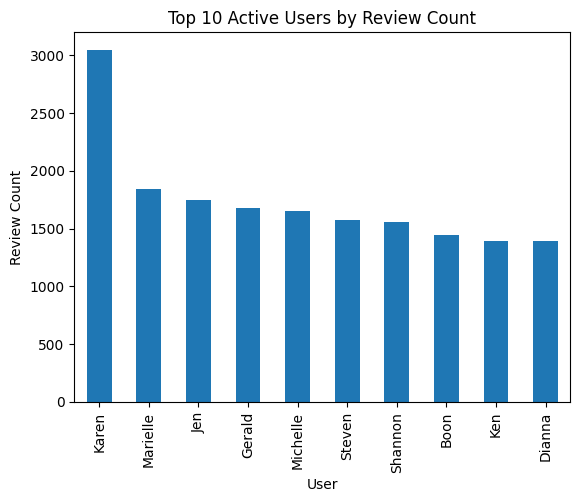

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame for visualization
top_users_pandas = top_users_df.limit(10).toPandas()

# Plot the top 10 users by review count
top_users_pandas.plot(kind='bar', x='name', y='review_count', legend=False)
plt.title("Top 10 Active Users by Review Count")
plt.xlabel("User")
plt.ylabel("Review Count")
plt.show()

In [15]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Define a function to get sentiment score from review text
def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

# Create a UDF (User Defined Function) for sentiment analysis
sentiment_udf = udf(get_sentiment, DoubleType())

# Add a sentiment score column to the user reviews DataFrame
user_reviews_with_sentiment_df = user_reviews_df.withColumn("sentiment_score", sentiment_udf(user_reviews_df["text"]))

# Show the first few rows with sentiment scores
user_reviews_with_sentiment_df.show(5)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dps/nltk_data...


+--------------------+----+--------------------+--------------------+------------+---------------+
|             user_id|name|                text|         business_id|review_count|sentiment_score|
+--------------------+----+--------------------+--------------------+------------+---------------+
|--6lqYpHZCBbpW5z2...|Jeff|Honestly was only...|mUI4DJagyUyu76qnR...|           9|         0.5624|
|--Kwhcbkh7jxkhVVQ...|Larz|The place is abso...|ORL4JE6tz3rJxVqkd...|          58|         0.8207|
|--Kwhcbkh7jxkhVVQ...|Larz|Ate dinner there ...|tIvfmgT1qMeAEQf8C...|          58|         0.9452|
|--Kwhcbkh7jxkhVVQ...|Larz|It was okay. If y...|Ld805G25xHALqbBo1...|          58|         0.9134|
|--Kwhcbkh7jxkhVVQ...|Larz|Went for a nice l...|arQfMJal1tl67Z96R...|          58|          0.902|
+--------------------+----+--------------------+--------------------+------------+---------------+
only showing top 5 rows



In [16]:
# Analyze sentiment by user review count
sentiment_by_review_count_df = user_reviews_with_sentiment_df.groupBy("user_id", "name", "review_count") \
                                                            .agg({"sentiment_score": "avg"}) \
                                                            .withColumnRenamed("avg(sentiment_score)", "avg_sentiment") \
                                                            .orderBy("review_count", ascending=False)

# Show the top 10 users by review count along with their average sentiment score
sentiment_by_review_count_df.show(10)


24/09/18 04:46:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:46:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:46:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:46:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:50:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:50:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:50:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:54:05 WARN RowBasedKeyValueBatch: Calling spill() on

KeyboardInterrupt: 